In [13]:
!pip install datasets
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
from datasets import load_dataset
from scipy.sparse import csr_matrix
import numpy as np
import joblib
from IPython.display import clear_output
clear_output()

### Data loading and viz

In [14]:
def prepare_data(df):
    texts = []
    labels = []
    for idx, row in df.iterrows():
        sentence = row['tokens']
        sentence_labels = row['fine_ner_tags']
        texts.extend(sentence)
        labels.append(sentence_labels)

    texts_vectorized = vectorizer.fit_transform(texts).toarray().tolist()

    merged_labels = [item for sublist in labels for item in sublist]
    return texts_vectorized, merged_labels

In [15]:
ds = load_dataset("DFKI-SLT/few-nerd", "supervised")

train_dataset = ds['train']
test_dataset = ds['test']

train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

df_exploded = train_df.explode(['tokens', 'ner_tags', 'fine_ner_tags']).reset_index(drop=True)
df_exploded = df_exploded.rename(columns={'tokens': 'token', 'ner_tags': 'ner_tag', 'fine_ner_tags': 'fine_ner_tag'})
train_df = df_exploded.drop(columns=['id','ner_tag'])

df_exploded = test_df.explode(['tokens', 'ner_tags', 'fine_ner_tags']).reset_index(drop=True)
df_exploded = df_exploded.rename(columns={'tokens': 'token', 'ner_tags': 'ner_tag', 'fine_ner_tags': 'fine_ner_tag'})
test_df = df_exploded.drop(columns=['id','ner_tag'])

In [16]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
    num_rows: 131767
})
Dataset({
    features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
    num_rows: 37648
})


In [17]:
from collections import Counter

# Function to count entities in each coarse tag
def count_entities_by_coarse_tag(dataset, tag_column='ner_tags'):
    coarse_tag_counts = Counter()
    for example in dataset:
        coarse_tag_counts.update(example[tag_column])
    return dict(coarse_tag_counts)

# Count entities in train and test datasets
train_coarse_tag_counts = count_entities_by_coarse_tag(train_dataset)
test_coarse_tag_counts = count_entities_by_coarse_tag(test_dataset)

# Display counts
print("Train Coarse Tag Counts:", train_coarse_tag_counts)
print("Test Coarse Tag Counts:", test_coarse_tag_counts)

train_tokens = sum(len(example['ner_tags']) for example in train_dataset)
test_tokens = sum(len(example['ner_tags']) for example in test_dataset)
print("train tokens: ", train_tokens )
print("test tokens: ", test_tokens )

Train Coarse Tag Counts: {0: 2547020, 7: 131967, 1: 43789, 5: 162886, 8: 44186, 3: 41539, 6: 63525, 4: 143445, 2: 49206}
Test Coarse Tag Counts: {0: 727983, 2: 13892, 4: 40989, 5: 46104, 3: 12162, 8: 12698, 7: 37301, 6: 17839, 1: 12150}
train tokens:  3227563
test tokens:  921118


In [18]:
vectorizer = TfidfVectorizer()
train_texts = train_df['token']
train_labels = train_df['fine_ner_tag']
train_texts = vectorizer.fit_transform(train_texts)

test_texts = test_df['token']
test_labels = test_df['fine_ner_tag']
test_texts = vectorizer.transform(test_texts)

In [19]:
print(train_texts.shape[0])
print(test_texts.shape[0])

3227563
921118


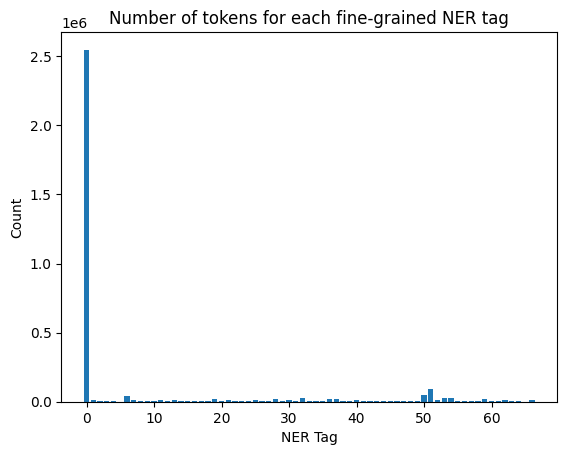

In [20]:
plt.bar(train_df['fine_ner_tag'].unique(), train_df['fine_ner_tag'].value_counts())
plt.xlabel('NER Tag')
plt.ylabel('Count')
plt.title('Number of tokens for each fine-grained NER tag')
plt.show()

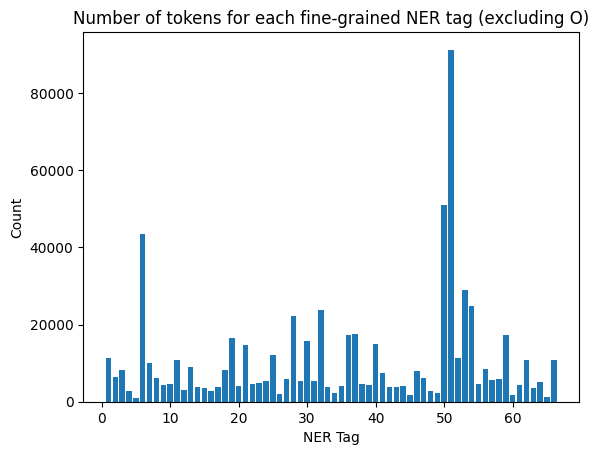

In [21]:
filtered_df = train_df[train_df['fine_ner_tag'] != 0]

plt.bar(filtered_df['fine_ner_tag'].unique(), filtered_df['fine_ner_tag'].value_counts())
plt.xlabel('NER Tag')
plt.ylabel('Count')
plt.title('Number of tokens for each fine-grained NER tag (excluding O)')
plt.show()


In [22]:
from sklearn.model_selection import train_test_split
train_labels = np.array(train_labels, dtype=int)
train_texts, _, train_labels, _ = train_test_split(train_texts, train_labels, test_size=0.9, random_state=42)
test_texts, _, test_labels, _ = train_test_split(test_texts, test_labels, test_size=0.9, random_state=42)

In [23]:
print(train_texts.shape[0])
print(test_texts.shape[0])

322756
92111


### *NB*

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(train_texts, train_labels)

y_pred = nb_model.predict(test_texts)
y_pred = np.array(y_pred, dtype=int)
test_labels = np.array(test_labels, dtype=int)
test_labels = test_labels.ravel()
y_pred = y_pred.ravel()

print("Naive Bayes Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

model_path = "naive_bayes_model.joblib"
joblib.dump(nb_model, model_path)
print(f"Model saved to {model_path}")

Naive Bayes Accuracy: 0.7950516224989415
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     72732
           1       0.00      0.00      0.00       147
           2       0.00      0.00      0.00       208
           3       0.00      0.00      0.00       308
           4       0.00      0.00      0.00       155
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00       335
           7       0.00      0.00      0.00       120
           8       0.00      0.00      0.00       112
           9       0.00      0.00      0.00        69
          10       0.00      0.00      0.00       124
          11       0.00      0.00      0.00       655
          12       0.00      0.00      0.00        52
          13       0.00      0.00      0.00       105
          14       0.00      0.00      0.00       137
          15       0.00      0.00      0.00       352
          16    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to naive_bayes_model.joblib


### DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(train_texts, train_labels)

y_pred = dt_model.predict(test_texts)
y_pred = np.array(y_pred, dtype=int)
test_labels = np.array(test_labels, dtype=int)
test_labels = test_labels.ravel()
y_pred = y_pred.ravel()

print("Decision Tree Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

model_path = "dt_model.joblib"
joblib.dump(dt_model, model_path)
print(f"Model saved to {model_path}")

Decision Tree Accuracy: 0.8205860320700025
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92     72732
           1       0.05      0.01      0.01       147
           2       0.09      0.02      0.04       208
           3       0.15      0.03      0.04       308
           4       0.07      0.01      0.02       155
           5       0.00      0.00      0.00        17
           6       0.08      0.01      0.02       335
           7       0.63      0.34      0.44       120
           8       0.50      0.28      0.36       112
           9       0.33      0.29      0.31        69
          10       0.59      0.28      0.38       124
          11       0.27      0.12      0.16       655
          12       0.27      0.08      0.12        52
          13       0.41      0.29      0.34       105
          14       0.55      0.38      0.45       137
          15       0.51      0.32      0.39       352
          16  

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(train_texts, train_labels)

y_pred = knn_model.predict(test_texts)
y_pred = np.array(y_pred, dtype=int).ravel()
test_labels_25 = np.array(test_labels, dtype=int).ravel()

print("KNN Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

model_path = "knn100_model.joblib"
joblib.dump(knn_model, model_path)
print(f"Model saved to {model_path}")

KNN Accuracy: 0.798210854295361
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89     72732
           1       0.00      0.00      0.00       147
           2       0.00      0.00      0.00       208
           3       0.00      0.00      0.00       308
           4       0.00      0.00      0.00       155
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00       335
           7       0.84      0.32      0.46       120
           8       0.63      0.21      0.32       112
           9       0.41      0.19      0.26        69
          10       0.74      0.25      0.37       124
          11       0.35      0.05      0.09       655
          12       0.00      0.00      0.00        52
          13       0.79      0.14      0.24       105
          14       0.81      0.22      0.34       137
          15       0.57      0.27      0.36       352
          16       0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(train_texts, train_labels)

y_pred = knn_model.predict(test_texts)
y_pred = np.array(y_pred, dtype=int).ravel()
test_labels = np.array(test_labels, dtype=int).ravel()

print("KNN Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

model_path = "knn2_model.joblib"
joblib.dump(knn_model, model_path)
print(f"Model saved to {model_path}")

KNN Accuracy: 0.800816406292408
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91     72732
           1       0.00      0.00      0.00       147
           2       0.03      0.01      0.02       208
           3       0.07      0.02      0.03       308
           4       0.02      0.01      0.02       155
           5       0.00      0.00      0.00        17
           6       0.08      0.02      0.03       335
           7       0.51      0.32      0.39       120
           8       0.11      0.06      0.08       112
           9       0.28      0.28      0.28        69
          10       0.40      0.29      0.34       124
          11       0.12      0.13      0.12       655
          12       0.14      0.04      0.06        52
          13       0.34      0.20      0.25       105
          14       0.14      0.12      0.13       137
          15       0.17      0.07      0.10       352
          16       0.05  

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=1000)
knn_model.fit(train_texts, train_labels)

y_pred = knn_model.predict(test_texts)
y_pred = np.array(y_pred, dtype=int).ravel()
test_labels_25 = np.array(test_labels, dtype=int).ravel()

print("KNN Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

model_path = "knn1000_model.joblib"
joblib.dump(knn_model, model_path)
print(f"Model saved to {model_path}")

KNN Accuracy: 0.7896125327051058
Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88     72732
           1       0.00      0.00      0.00       147
           2       0.00      0.00      0.00       208
           3       0.00      0.00      0.00       308
           4       0.00      0.00      0.00       155
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00       335
           7       0.00      0.00      0.00       120
           8       0.00      0.00      0.00       112
           9       0.00      0.00      0.00        69
          10       0.00      0.00      0.00       124
          11       0.00      0.00      0.00       655
          12       0.00      0.00      0.00        52
          13       0.00      0.00      0.00       105
          14       0.00      0.00      0.00       137
          15       0.00      0.00      0.00       352
          16       0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### SVM

In [25]:
from sklearn.svm import SVC

svm_modell = SVC(kernel='linear')
svm_modell.fit(train_texts, train_labels)

y_pred = svm_modell.predict(test_texts)

y_pred = np.array(y_pred, dtype=int)
test_labels = np.array(test_labels, dtype=int)
test_labels = test_labels.ravel()
y_pred = y_pred.ravel()

print("SVM Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

model_path = "svm_modell.joblib"
joblib.dump(svm_modell, model_path)
print(f"Model saved to {model_path}")

SVM Accuracy: 0.8210094342695227
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92     72732
           1       0.00      0.00      0.00       147
           2       0.13      0.02      0.03       208
           3       0.20      0.03      0.05       308
           4       0.08      0.01      0.01       155
           5       0.00      0.00      0.00        17
           6       0.11      0.01      0.02       335
           7       0.78      0.32      0.45       120
           8       0.55      0.21      0.31       112
           9       0.44      0.25      0.31        69
          10       0.72      0.25      0.37       124
          11       0.27      0.11      0.15       655
          12       0.33      0.02      0.04        52
          13       0.48      0.28      0.35       105
          14       0.64      0.37      0.47       137
          15       0.52      0.31      0.39       352
          16       0.50 

/home/142402022/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/142402022/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/142402022/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to svm_modell.joblib


In [ ]:
from sklearn.svm import SVC

svm_modelp = SVC(kernel='poly', degree=3)
svm_modelp.fit(train_texts, train_labels)

y_pred = svm_modelp.predict(test_texts)

y_pred = np.array(y_pred, dtype=int)
test_labels = np.array(test_labels, dtype=int)
test_labels = test_labels.ravel()
y_pred = y_pred.ravel()

print("SVM Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

model_path = "svm_modelp.joblib"
joblib.dump(svm_modelp, model_path)
print(f"Model saved to {model_path}")

SVM Accuracy: 0.8213134153358448


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92     72732
           1       0.10      0.01      0.01       147
           2       0.14      0.02      0.04       208
           3       0.20      0.03      0.05       308
           4       0.13      0.01      0.02       155
           5       0.00      0.00      0.00        17
           6       0.11      0.01      0.02       335
           7       0.71      0.34      0.46       120
           8       0.57      0.25      0.35       112
           9       0.44      0.28      0.34        69
          10       0.66      0.27      0.38       124
          11       0.29      0.11      0.16       655
          12       0.36      0.08      0.13        52
          13       0.49      0.28      0.35       105
          14       0.63      0.37      0.47       137
          15       0.52      0.31      0.39       352
          16       0.35      0.12      0.18        49
   

In [ ]:
from sklearn.svm import SVC

svm_modelr = SVC(kernel='rbf', C=1, gamma=0.01)
svm_modelr.fit(train_texts, train_labels)

y_pred = svm_modelr.predict(test_texts)

y_pred = np.array(y_pred, dtype=int)
test_labels = np.array(test_labels, dtype=int)
test_labels = test_labels.ravel()
y_pred = y_pred.ravel()

print("SVM Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

model_path = "svm_modelr.joblib"
joblib.dump(svm_modelr, model_path)
print(f"Model saved to {model_path}")

### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

rf_model = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500], 
    'max_depth': [None, 10, 20, 30, 40], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'], 
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=50, random_state=42, n_jobs=-1, cv=5, verbose=2)

random_search.fit(train_texts, train_labels)
best_rf_model = random_search.best_estimator_

y_pred = best_rf_model.predict(test_texts)
y_pred = np.array(y_pred, dtype=int)
test_labels = np.array(test_labels, dtype=int)
test_labels = test_labels.ravel()
y_pred = y_pred.ravel()

print("Optimized Random Forest Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

print("Best Parameters found:", random_search.best_params_)

model_path = "random_forest_model.joblib"
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
